In [30]:
!apt-get install cuda=10.2.89-1
!pip install pykeops[full]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cuda is already the newest version (10.2.89-1).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.


In [31]:
!git clone https://github.com/jeanfeydy/monaco.git
import os.path
import sys
sys.path.append('monaco')
sys.setrecursionlimit(10000)

fatal: destination path 'monaco' already exists and is not an empty directory.


In [32]:
import numpy as np
import torch
from matplotlib import pyplot as plt

plt.rcParams.update({"figure.max_open_warning": 0})

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


In [33]:
import pykeops
pykeops.clean_pykeops()          # just in case old build files are still present
pykeops.test_torch_bindings() 

Cleaning /root/.cache/pykeops-1.5-cpython-37/...
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorch180bebcc11 has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorch63a5ccf90a has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorch9f7df05215 has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorchee0849eb6c has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorch271660f93e has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorch7dac3e6dad has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorchd74f97fd1e has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/build-6f516b652b has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/build-pybind11_template-libKeOps_template_574e4b20be has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorchca797b4a41 has been removed.
    - /root/.cache/pykeops-1.5-cpython-37/libKeOpstorch8ea66c7594 has been removed.
    -

In [34]:
from monaco.euclidean import EuclideanSpace

D = 2
space = EuclideanSpace(dimension=D, dtype=dtype)

In [35]:
from monaco.euclidean import GaussianMixture, UnitPotential

N, M = (10000 if use_cuda else 50), 5
nruns = 10
niter = 80


test_case = "gaussians"

if test_case == "gaussians":
    # Let's generate a blend of peaky Gaussians, in the unit square:
    m = torch.tensor([[0.2,0.8],[0.8,0.8],[0.5,0.1]]).type(dtype)  # mean
    s = torch.tensor([0.02,0.02,0.02]).type(dtype)  # deviation
    w = torch.tensor([0.3,0.3,0.4]).type(dtype)  # weights
    w = w**2
    
    w = w / w.sum()  # normalize weights

    distribution_gauss = GaussianMixture(space, m, s, w)

print(m)
print(s)
print(w)

tensor([[0.2000, 0.8000],
        [0.8000, 0.8000],
        [0.5000, 0.1000]], device='cuda:0')
tensor([0.0200, 0.0200, 0.0200], device='cuda:0')
tensor([0.2647, 0.2647, 0.4706], device='cuda:0')


[pyKeOps] Compiling libKeOpstorch9f7df05215 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Max_SumShiftExp_Reduction(((((Minus(Sum(Square((Var(0,2,0) - Var(1,2,1))))) / (IntCst(2) * Square(Var(2,1,1)))) + Log(Var(3,1,1))) - Var(4,1,2)) - (IntCst(2) * Log(Var(2,1,1)))),0)
       aliases: Var(0,2,0); Var(1,2,1); Var(2,1,1); Var(3,1,1); Var(4,1,2); 
       dtype  : float32
... 
Done.
tensor([  5.1233,   1.0361,   1.0361,   0.4608, 162.8430], device='cuda:0')
[pyKeOps] Compiling libKeOpstorch63a5ccf90a in /root/.cache/pykeops-1.5-cpython-37:
       formula: Max_SumShiftExp_Reduction(((((Minus(Sum(Square((Var(0,2,2) - Var(1,2,1))))) / (IntCst(2) * Square(Var(2,1,1)))) + Log(Var(3,1,1))) - Var(4,1,2)) - (IntCst(2) * Log(Var(2,1,1)))),0)
       aliases: Var(0,2,2); Var(1,2,1); Var(2,1,1); Var(3,1,1); Var(4,1,2); 
       dtype  : float32
... 
Done.


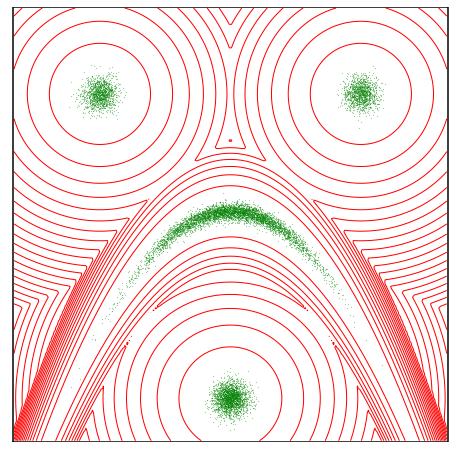

In [36]:
from monaco.euclidean import GaussianMixture, UnitPotential
from torch.distributions.multivariate_normal import MultivariateNormal


space = EuclideanSpace(dimension=D, dtype=dtype)

def sinc_potential(x, stripes=3):
    sqnorm = (x ** 2).sum(-1)
    V_i = np.pi * stripes * sqnorm
    V_i = (V_i.sin() / V_i) ** 2
    return -V_i.log()
    
def banana_log_pdf(x):
    b=.03
    y = x.clone().detach()
    y[:,1] = y[:,1]+b*y[:,0]**2-100.*b
    return -.5*(y[:,0]**2/100.+y[:,1]**2)-4.1404621594


def banana_potential_plus(x):
    # Add a constant for the rejection sampling
    return -banana_log_pdf(100*(x-.5))-9.21034037198

distribution_banana = UnitPotential(space, banana_potential_plus)

alpha = torch.tensor(.5).type(dtype)

def mix_potential_plus(x):
    #Add a constant for the rejection
    A = -banana_potential_plus(x) + alpha.log()
    B = -distribution_gauss.potential(x) + (1-alpha).log()
    AB = torch.cat((A[:,None],B[:,None]),dim=1)
    C = AB.logsumexp(dim=1)
    return -C+5

distribution = UnitPotential(space, mix_potential_plus)

print(mix_potential_plus(torch.tensor([[.5,.5],[.2,.8],[.8,.8],[.5,.1],[.5,1]]).type(dtype)))

plt.figure(figsize=(8, 8))
space.scatter(distribution.sample(N), "green")
space.plot(distribution.potential, "red")
space.draw_frame()


In [37]:

perfect_sample = distribution.sample(N)
def perfect_sampling(*args,**kwargs):
    return perfect_sample
distribution.sample = perfect_sampling

In [38]:

def mix_potential0(x):
    A = -banana_potential_plus(x) + alpha.log()
    B = -distribution_gauss.potential(x) + (1-alpha).log()
    AB = torch.cat((A[:,None],B[:,None]),dim=1)
    C = AB.logsumexp(dim=1)
    return -C+4
distribution.potential = mix_potential0
mix_potential0(torch.tensor([[0.5,0.5],[.2,.8],[.8,.8],[.5,.2]]).type(dtype))

tensor([ 4.1233,  0.0361,  0.0361, 11.9608], device='cuda:0')

In [39]:
#start = torch.rand(N, D).type(dtype)#uniform start
start = 0.9 + 0.1*torch.rand(N, D).type(dtype) #start in a corner
#start=0.75+0.1*torch.rand(N, D).type(dtype) #start in a minor mode

In [40]:
from monaco.euclidean import UniformProposal
from monaco.euclidean import GaussianProposal

exploration = .05
#exploration = None
exploration_proposal = GaussianProposal(space,scale=.3)
annealing = None

In [41]:
from monaco.euclidean import BallProposal

scale = [.1]

proposal = BallProposal(space, scale=scale,
                        exploration=exploration, exploration_proposal=exploration_proposal)

In [42]:
from monaco.samplers import display_samples
info = {}

[pyKeOps] Compiling libKeOpstorch271660f93e in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction(Sqrt(Sum(Square((Var(0,2,0) - Var(1,2,1))))),0)
       aliases: Var(0,2,0); Var(1,2,1); 
       dtype  : float32
... 
Done.


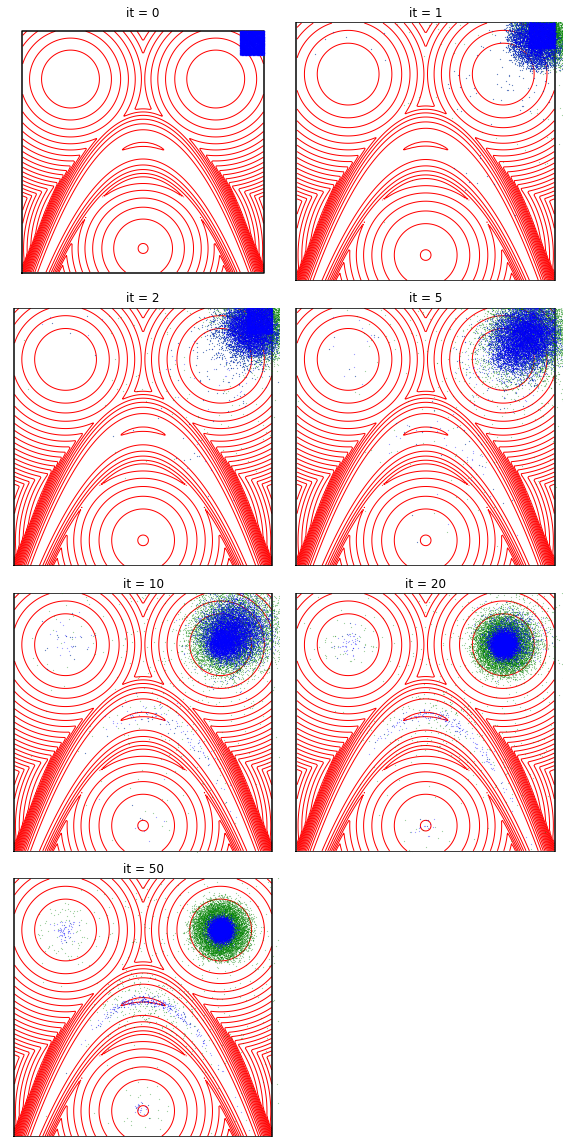

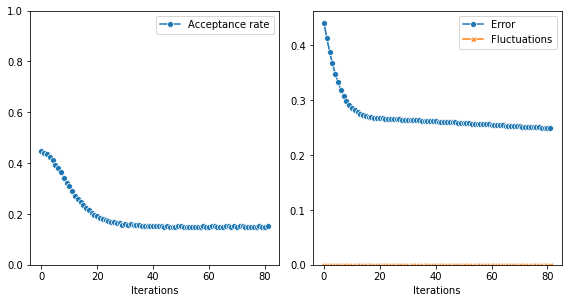

In [43]:
from monaco.samplers import ParallelMetropolisHastings

pmh_sampler = ParallelMetropolisHastings(space, start, proposal, annealing=annealing).fit(
    distribution
)
info["PMH"] = display_samples(pmh_sampler, iterations=niter, runs=nruns)

[pyKeOps] Compiling libKeOpstorch8ea66c7594 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction(((Step((Square(Var(0,1,2)) - Sum(Square((Var(1,2,0) - Var(2,2,1)))))) / (Var(3,1,2) * Square(Var(0,1,2)))) / IntCst(10000)),0)
       aliases: Var(0,1,2); Var(1,2,0); Var(2,2,1); Var(3,1,2); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpstorchd74f97fd1e in /root/.cache/pykeops-1.5-cpython-37:
       formula: Max_SumShiftExp_Reduction(((((Minus(Sum(Square((Var(0,2,0) - Var(1,2,1))))) / (IntCst(2) * Square(Var(2,1,2)))) - Var(3,1,2)) - (IntCst(2) * Log(Var(2,1,2)))) - Var(4,1,2)),0)
       aliases: Var(0,2,0); Var(1,2,1); Var(2,1,2); Var(3,1,2); Var(4,1,2); 
       dtype  : float32
... 
Done.


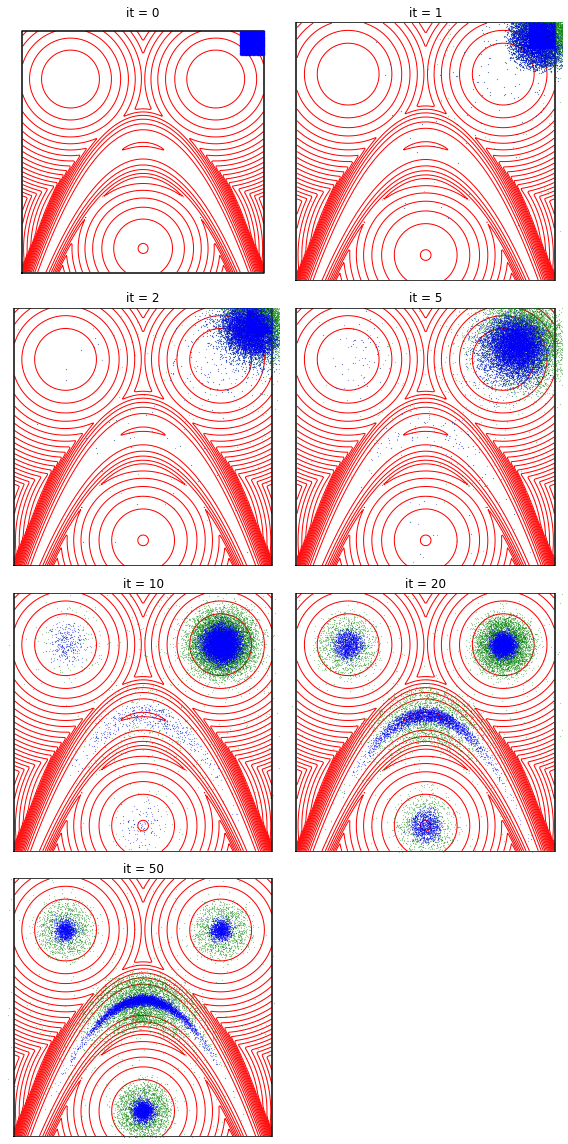

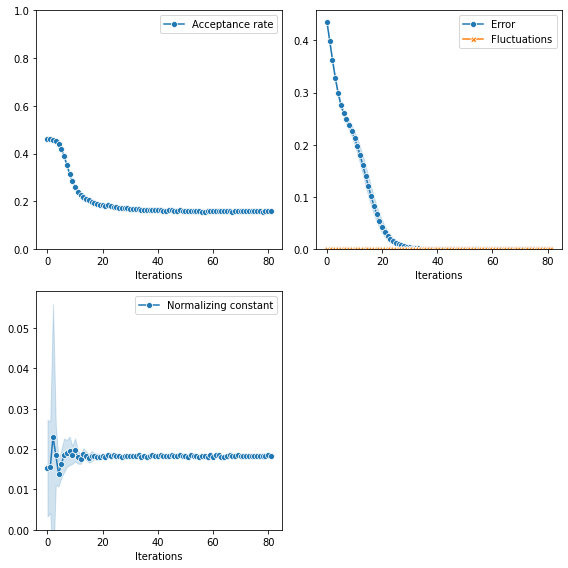

In [44]:
from monaco.samplers import CMC
scale = .1

proposal = BallProposal(space, scale=scale,
                        exploration=exploration, exploration_proposal=exploration_proposal)

cmc_sampler = CMC(space, start, proposal, annealing=None).fit(distribution)
info["CMC"] = display_samples(cmc_sampler, iterations=niter, runs=nruns)

[pyKeOps] Compiling libKeOpstorch7dac3e6dad in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction(((Step((Square(Var(0,4,2)) - Sum(Square((Var(1,2,0) - Var(2,2,1)))))) / (Var(3,1,2) * Square(Var(0,4,2)))) / IntCst(10000)),0)
       aliases: Var(0,4,2); Var(1,2,0); Var(2,2,1); Var(3,1,2); 
       dtype  : float32
... 
Done.


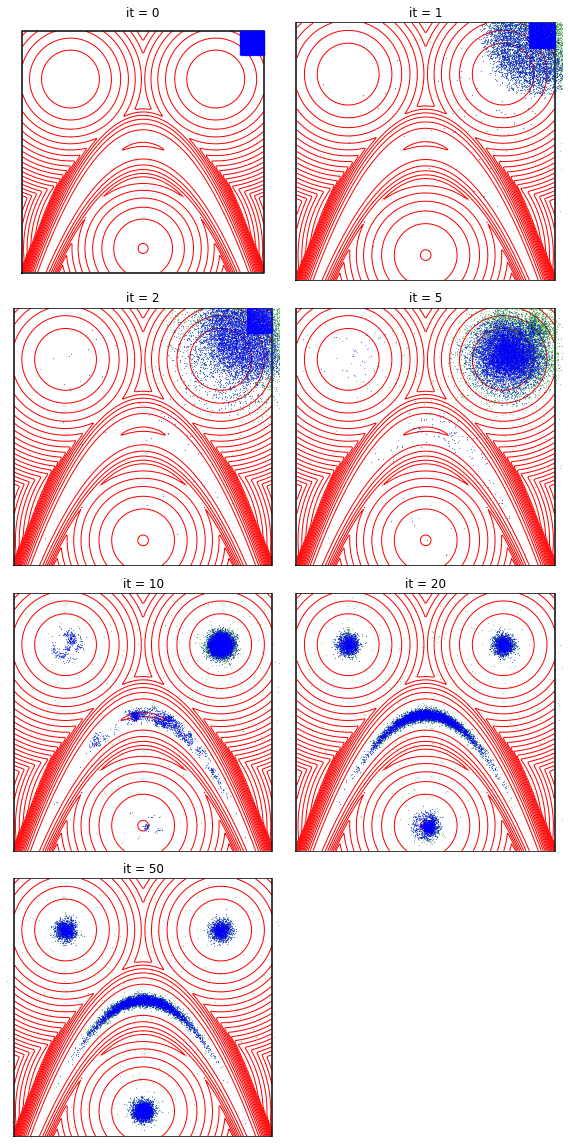

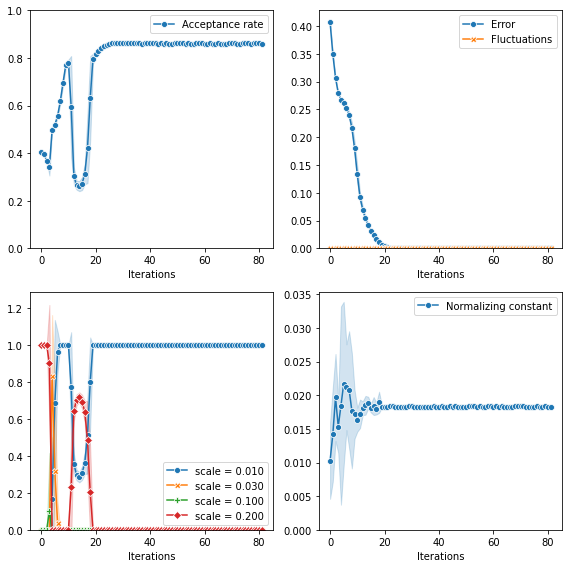

In [45]:
from monaco.samplers import MOKA_Markov_CMC

multi_scale = [0.01, 0.03, 0.1, .2]

proposal = BallProposal(space, scale=multi_scale,
                        exploration=exploration, exploration_proposal=exploration_proposal)

moka_markov_sampler = MOKA_Markov_CMC(space, start, proposal, annealing=annealing).fit(distribution)
info["MOKA Markov"] = display_samples(moka_markov_sampler, iterations=niter, runs=nruns)

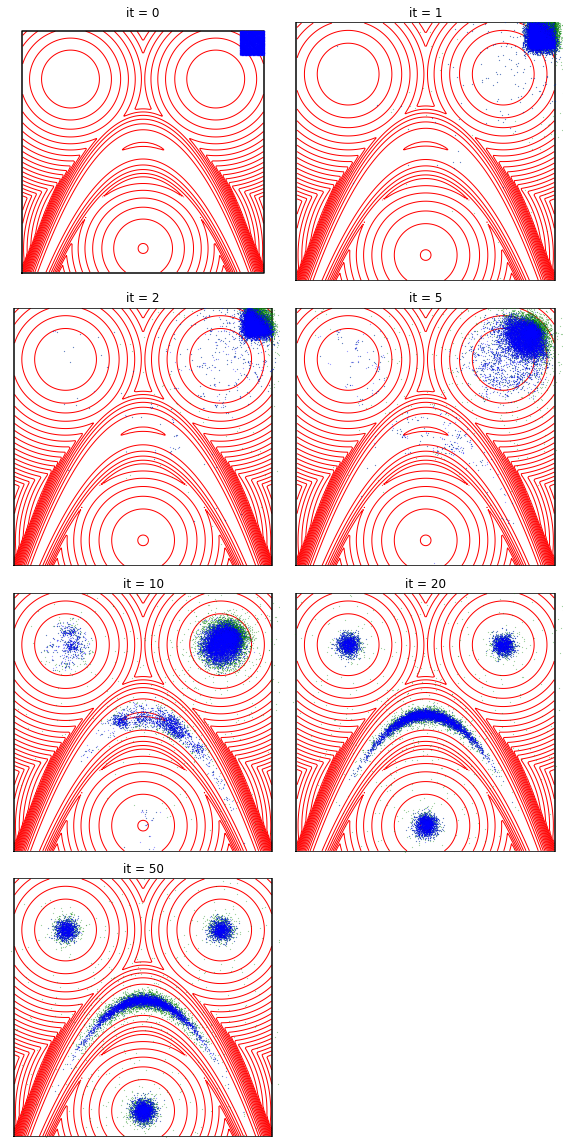

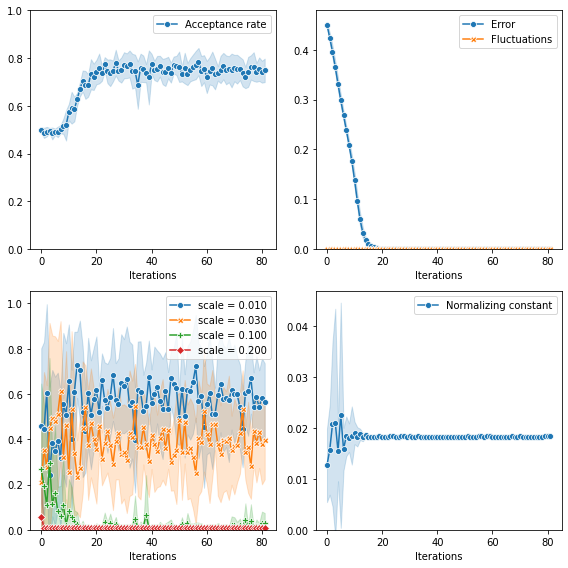

In [46]:
from monaco.samplers import MOKA_CMC

proposal = BallProposal(space, scale=multi_scale,
                        exploration=exploration, exploration_proposal=exploration_proposal)

moka_sampler = MOKA_CMC(space, start, proposal, annealing=annealing).fit(distribution)
info["MOKA"] = display_samples(moka_sampler, iterations=niter, runs=nruns)

[pyKeOps] Compiling libKeOpstorch17bc5fdcb4 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction(((Step((Square(Var(0,1,2)) - Sum(Square((Var(1,2,0) - Var(2,2,1)))))) / (Var(3,1,2) * Square(Var(0,1,2)))) * Var(4,1,1)),0)
       aliases: Var(0,1,2); Var(1,2,0); Var(2,2,1); Var(3,1,2); Var(4,1,1); 
       dtype  : float32
... 
Done.
[pyKeOps] Compiling libKeOpstorchca797b4a41 in /root/.cache/pykeops-1.5-cpython-37:
       formula: Max_SumShiftExp_Reduction(((((Minus(Sum(Square((Var(0,2,0) - Var(1,2,1))))) / (IntCst(2) * Square(Var(2,1,2)))) - Var(3,1,2)) - (IntCst(2) * Log(Var(2,1,2)))) + Var(4,1,1)),0)
       aliases: Var(0,2,0); Var(1,2,1); Var(2,1,2); Var(3,1,2); Var(4,1,1); 
       dtype  : float32
... 
Done.


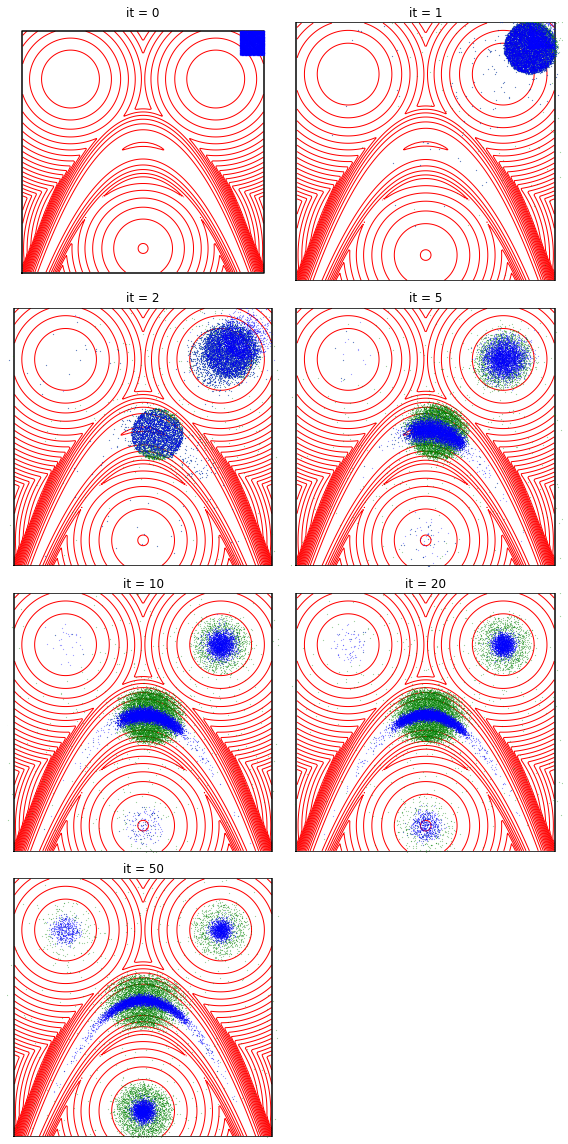

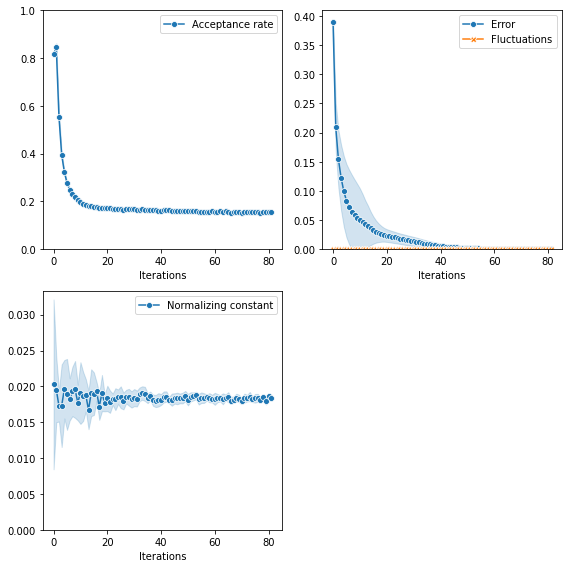

In [47]:
from monaco.samplers import KIDS_CMC

proposal = BallProposal(space, scale=.1,
                        exploration=exploration, exploration_proposal=exploration_proposal)

kids_sampler = KIDS_CMC(space, start, proposal, annealing=annealing, iterations=20).fit(
    distribution
)
info["KIDS"] = display_samples(kids_sampler, iterations=niter, runs=nruns)

[pyKeOps] Compiling libKeOpstorchee0849eb6c in /root/.cache/pykeops-1.5-cpython-37:
       formula: Sum_Reduction(((Step((Square(Var(0,4,2)) - Sum(Square((Var(1,2,0) - Var(2,2,1)))))) / (Var(3,1,2) * Square(Var(0,4,2)))) * Var(4,1,1)),0)
       aliases: Var(0,4,2); Var(1,2,0); Var(2,2,1); Var(3,1,2); Var(4,1,1); 
       dtype  : float32
... 
Done.


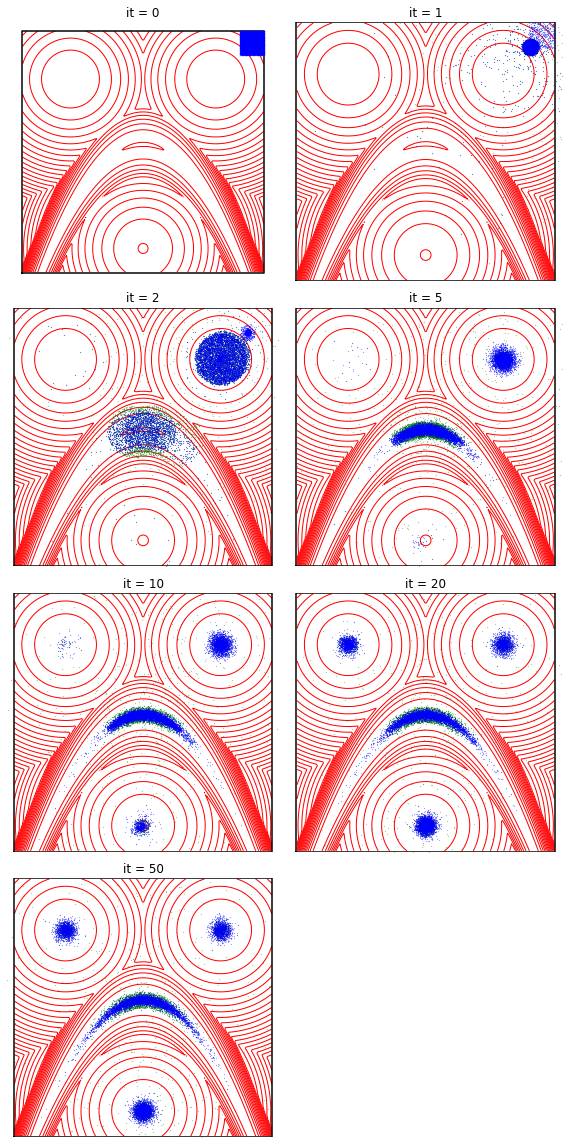

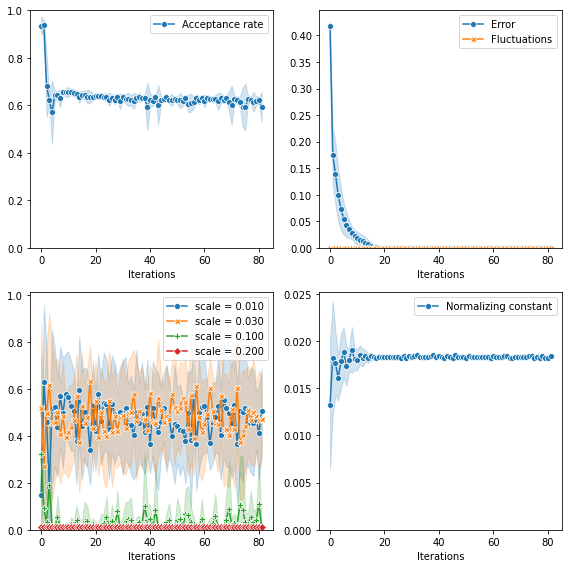

In [48]:
from monaco.samplers import MOKA_KIDS_CMC

proposal = BallProposal(space, scale=[0.01, 0.03, 0.1, .2],
                        exploration=exploration, exploration_proposal=exploration_proposal)

moka_kids_sampler = MOKA_KIDS_CMC(space, start, proposal, annealing=annealing, iterations=20).fit(
    distribution
)
info["MOKA_KIDS"] = display_samples(moka_kids_sampler, iterations=niter, runs=nruns)

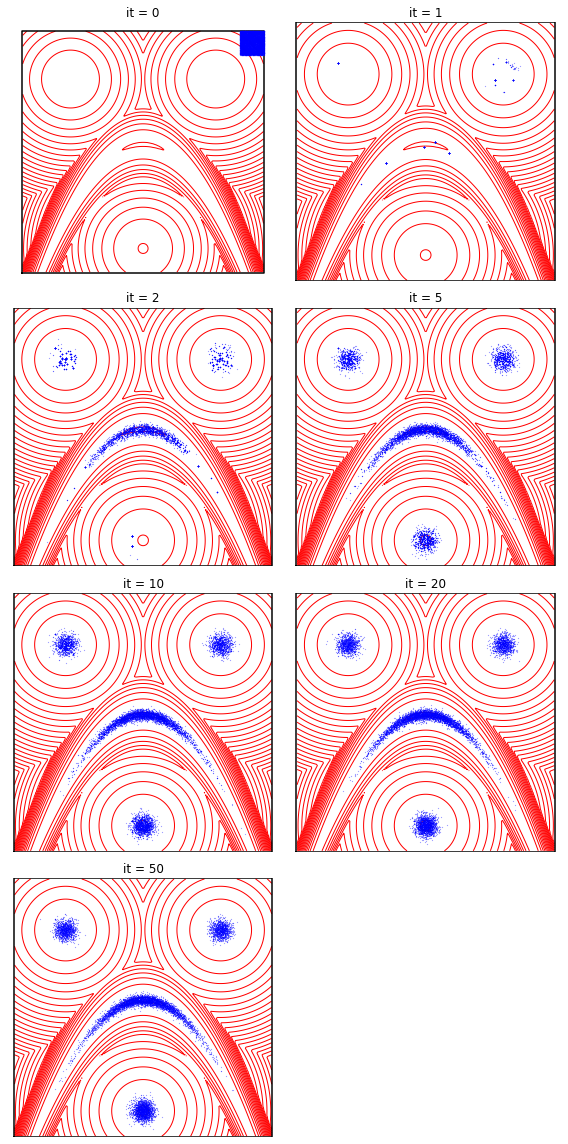

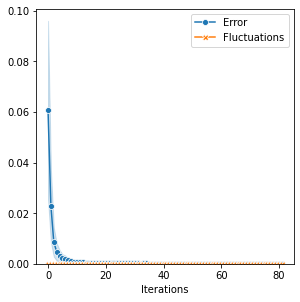

In [49]:
from monaco.samplers import NPAIS

proposal = BallProposal(space, scale=0.1,
                        exploration=exploration, exploration_proposal=exploration_proposal)


class Q_0(object):
    def __init__(self):
        None

    def sample(self, n):
        return 0.9 + 0.1 * torch.rand(n, D).type(dtype)
        

    def potential(self, x):
        v = 100000 * torch.ones(len(x), 1).type_as(x)
        v[(x - 0.95).abs().max(1)[0] < 0.05] = -np.log(1 / 0.1)
        return v.view(-1)


q0 = Q_0()

npais_sampler = NPAIS(space, start, proposal, annealing=annealing, q0=q0, N=N).fit(
    distribution
)
info["SAIS"] = display_samples(npais_sampler, iterations=niter, runs=nruns)

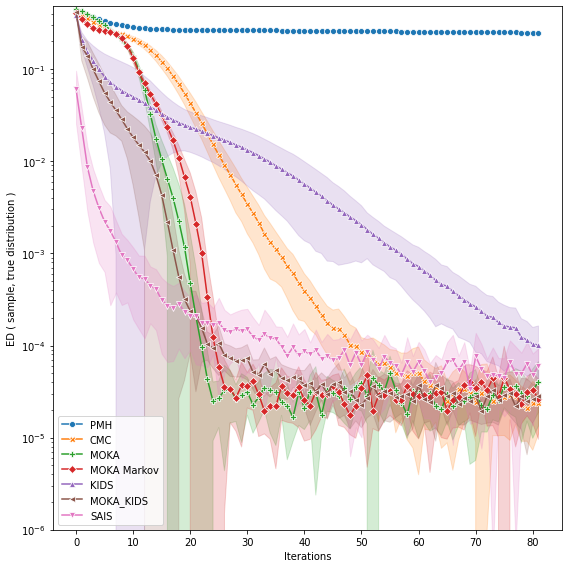

In [55]:
import itertools
import seaborn as sns

iters = info["PMH"]["iteration"]


def display_line(key, marker):
    sns.lineplot(
        x=info[key]["iteration"],
        y=info[key]["error"],
        label=key,
        marker=marker,
        markersize=6,
        ci="sd",
    )


plt.figure(figsize=(8, 8))
markers = itertools.cycle(("o", "X", "P", "D", "^", "<", "v", ">", "*"))

for key, marker in zip(["PMH", "CMC","MOKA", "MOKA Markov","KIDS", "MOKA_KIDS", "SAIS"], markers):
    display_line(key, marker)


plt.xlabel("Iterations")
plt.ylabel("ED ( sample, true distribution )")
plt.ylim(bottom=1e-6)
plt.yscale("log")

plt.tight_layout()


plt.show()

In [59]:
print(((cmc_sampler.x.sum(0)/N-m.sum(0)/2)**2).sum().log())
print(((npais_sampler.x.sum(0)/N-m.sum(0)/2)**2).sum().log())

tensor(-1.6278, device='cuda:0')
tensor(-2.9991, device='cuda:0')


In [51]:
import csv
from google.colab import files
with open('test.csv', 'w') as f:
    for key in info["CMC"].keys():
        f.write("%s,%s\n"%(key,info["CMC"][key]))
#files.download("test.csv")
print(info["MOKA"])
#len(info["CMC"]["normalizing constant"])
#len(info["CMC"]["error"])

{'iteration': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 

In [52]:
import pandas as pd

In [53]:
df = pd.DataFrame(info["CMC"])

ValueError: ignored